## Instalar librerias

In [1]:
!pip3 install imbalanced-learn
!pip3 install nltk

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ------------------- -------------------- 112.6/235.6 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 4.9 MB/s eta 0:00:00


## Importar librerias

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import string
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import re
from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import tensorflow as tf
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK
from keras.regularizers import L2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Se acondiciona donde se guardara el modelo

In [36]:
MODELS_DIR = Path("models/")
Params_dir = Path("params/")
SKLEARN_SVMMODEL_PATH = MODELS_DIR.joinpath("sklearn/linkScibe_SVMmodel.pk")
CountVectorizer_PATH = Params_dir.joinpath("CountVectorizer.pk")
TfidfTransformer_PATH = Params_dir.joinpath("TfidfTransformer.pk")
le_PATH = Params_dir.joinpath("le.pk")
SKLEARN_LRMODEL_PATH = MODELS_DIR.joinpath("sklearn/linkScibe_LRmodel.pk")
SKLEARN_RFMODEL_PATH = MODELS_DIR.joinpath("sklearn/linkScibe_RFmodel.pk")
TF_MODEL_PATH = MODELS_DIR.joinpath("tf/Linscribe_model")

SKLEARN_SVMMODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
SKLEARN_LRMODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
SKLEARN_RFMODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
TF_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
CountVectorizer_PATH.parent.mkdir(exist_ok=True, parents=True)
TfidfTransformer_PATH.parent.mkdir(exist_ok=True, parents=True)
le_PATH.parent.mkdir(exist_ok=True, parents=True)

## Carga del dataset

In [37]:
df = pd.read_csv("website_classification.csv", usecols= ["cleaned_website_text", "Category"])

In [38]:
df.head()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


Check for missing values

In [39]:
df.isnull().sum()

cleaned_website_text    0
Category                0
dtype: int64

In [40]:
df['Category'].value_counts()

Category
Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: count, dtype: int64

## Visualizar las categorias a clasificar

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Travel'),
  Text(1, 0, 'Social Networking and Messaging'),
  Text(2, 0, 'News'),
  Text(3, 0, 'Streaming Services'),
  Text(4, 0, 'Sports'),
  Text(5, 0, 'Photography'),
  Text(6, 0, 'Law and Government'),
  Text(7, 0, 'Health and Fitness'),
  Text(8, 0, 'Games'),
  Text(9, 0, 'E-Commerce'),
  Text(10, 0, 'Forums'),
  Text(11, 0, 'Food'),
  Text(12, 0, 'Education'),
  Text(13, 0, 'Computers and Technology'),
  Text(14, 0, 'Business/Corporate'),
  Text(15, 0, 'Adult')])

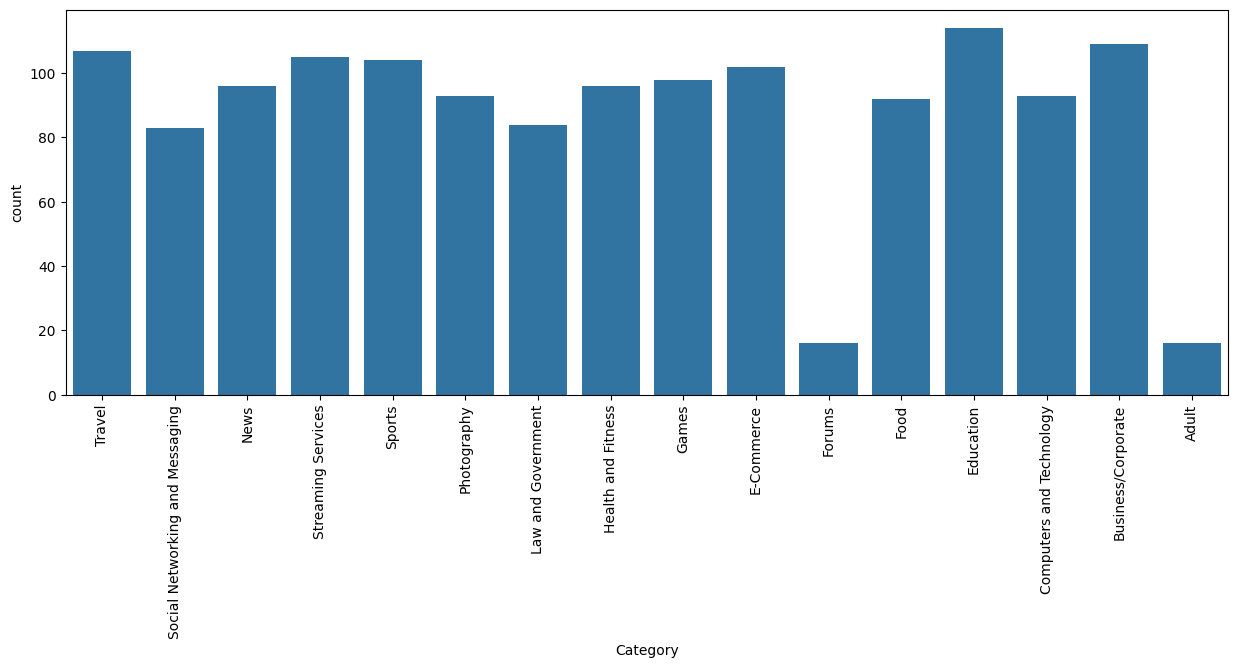

In [41]:
plt.figure(figsize=(15,5))
sns.countplot(x = 'Category', data=df)
plt.xticks(rotation = 90)

## PREPRO

In [42]:
df['cleaned_website_text']= df['cleaned_website_text'].apply(lambda x:x.lower())

In [43]:
df['tokenized_words'] = df['cleaned_website_text'].apply(lambda x:word_tokenize(x))

In [30]:
df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [44]:
df['tokenized_words'] = df['tokenized_words'].apply(lambda x:[re.sub(f'[{string.punctuation}]+','',i) for i in x if i not in list(string.punctuation)])

In [32]:
df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [45]:
df['tokenized_words'] = df['tokenized_words'].apply(lambda x:[i for i in x if i not in stopwords.words('english')])
df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [46]:
df['tokenized_words']= df['tokenized_words'].apply(lambda x:' '.join(x))

In [47]:
df.drop(['cleaned_website_text'],axis=1,inplace=True)

In [48]:
### changing the order of columns and renaming them

df=df[['tokenized_words','Category']]
df.columns=['Website Cleaned Text','Category']
df

,Website Cleaned Text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel
...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,porno dvd online european porn dvd cheap adult...,Adult
1406,anal dream house anal dream house anal dream h...,Adult


## Dividir el dataset en X Y

In [49]:
X = df['Website Cleaned Text']
Y = df['Category']

In [50]:
count = CountVectorizer().fit(X)
pickle.dump(count, open(CountVectorizer_PATH, 'wb'))

In [51]:
X_count = count.transform(X)
print(X_count)

  (0, 1050)	4
  (0, 1070)	4
  (0, 1301)	1
  (0, 1462)	1
  (0, 1467)	2
  (0, 1587)	1
  (0, 1699)	1
  (0, 1885)	1
  (0, 2163)	1
  (0, 2270)	1
  (0, 2639)	1
  (0, 2864)	1
  (0, 3142)	1
  (0, 3143)	10
  (0, 3144)	2
  (0, 3350)	1
  (0, 4311)	1
  (0, 4798)	2
  (0, 5009)	1
  (0, 5282)	1
  (0, 5547)	1
  (0, 6309)	1
  (0, 6795)	1
  (0, 6962)	1
  (0, 6965)	2
  :	:
  (1407, 56020)	1
  (1407, 56820)	1
  (1407, 56828)	4
  (1407, 56838)	1
  (1407, 56862)	1
  (1407, 57035)	1
  (1407, 57038)	1
  (1407, 57233)	2
  (1407, 57248)	1
  (1407, 57577)	1
  (1407, 57678)	1
  (1407, 57814)	1
  (1407, 57826)	1
  (1407, 57828)	1
  (1407, 57903)	1
  (1407, 57932)	1
  (1407, 58402)	1
  (1407, 58554)	3
  (1407, 58564)	1
  (1407, 58663)	9
  (1407, 58677)	1
  (1407, 58684)	1
  (1407, 58945)	2
  (1407, 59003)	4
  (1407, 59113)	1


In [52]:
Tfidf = TfidfTransformer().fit(X_count)
pickle.dump(Tfidf, open(TfidfTransformer_PATH, 'wb'))

In [53]:
X_tfid = Tfidf.transform(X_count)
print(X_tfid)

  (0, 59988)	0.024502342045692745
  (0, 59973)	0.03163419860320906
  (0, 59969)	0.027810131989300536
  (0, 59960)	0.022764887896070028
  (0, 59922)	0.03163419860320906
  (0, 59815)	0.024502342045692745
  (0, 59803)	0.02852814589910457
  (0, 59783)	0.02815630633841439
  (0, 59759)	0.023417434399081647
  (0, 59720)	0.028929763220329377
  (0, 59708)	0.028929763220329377
  (0, 59691)	0.02815630633841439
  (0, 59678)	0.032407655485124046
  (0, 58805)	0.03791998430637177
  (0, 58800)	0.03791998430637177
  (0, 58677)	0.017678028913267318
  (0, 58663)	0.00949716188945847
  (0, 58630)	0.03866066255083005
  (0, 58613)	0.016711685694573625
  (0, 58402)	0.034921571096896184
  (0, 58269)	0.022764887896070028
  (0, 57900)	0.01953792481306217
  (0, 57761)	0.011090669491753805
  (0, 57611)	0.07583996861274354
  (0, 57577)	0.033782315438822055
  :	:
  (1407, 3695)	0.015371124588623324
  (1407, 3689)	0.010019145421133961
  (1407, 3447)	0.011514140219830498
  (1407, 3314)	0.023933062882012753
  (1407, 33

In [42]:
print(X_count.shape)
print(X_tfid.shape)

(1408, 59995)
(1408, 59995)


## Dividir el dataset en entrenamiento y validacion

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_tfid, Y, test_size=0.30)

In [71]:
x_train_array = X_train.toarray()

In [72]:
x_train_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
X_test_array = X_test.toarray()

In [74]:
y_train.value_counts()

Category
Education                          80
Health and Fitness                 75
E-Commerce                         74
Business/Corporate                 73
Travel                             72
Sports                             72
News                               71
Streaming Services                 70
Food                               68
Computers and Technology           66
Photography                        65
Games                              64
Social Networking and Messaging    60
Law and Government                 56
Forums                             12
Adult                               7
Name: count, dtype: int64

In [75]:
le = LabelEncoder()
le.fit(y_train)
pickle.dump(le, open(le_PATH, 'wb'))
y_train_enco = le.transform(y_train)

In [28]:
y_test.value_counts()

Category
Business/Corporate                 42
Education                          38
E-Commerce                         33
Law and Government                 31
Sports                             31
Computers and Technology           30
Travel                             30
News                               30
Photography                        28
Streaming Services                 27
Food                               26
Games                              26
Social Networking and Messaging    23
Health and Fitness                 19
Adult                               5
Forums                              4
Name: count, dtype: int64

In [29]:
y_test_enco = le.transform(y_test)

In [30]:
a = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

In [31]:
labels = le.inverse_transform(a)

In [32]:
labels

array(['Adult', 'Business/Corporate', 'Computers and Technology',
       'E-Commerce', 'Education', 'Food', 'Forums', 'Games',
       'Health and Fitness', 'Law and Government', 'News', 'Photography',
       'Social Networking and Messaging', 'Sports', 'Streaming Services',
       'Travel'], dtype=object)

## SVM

In [270]:
Svm = svm.SVC()
Svm.fit(x_train_array, y_train_enco)

SVC()

In [271]:
Svmpredic= Svm.predict(X_test_array)

In [272]:
cm_svm = confusion_matrix(y_test_enco,Svmpredic)

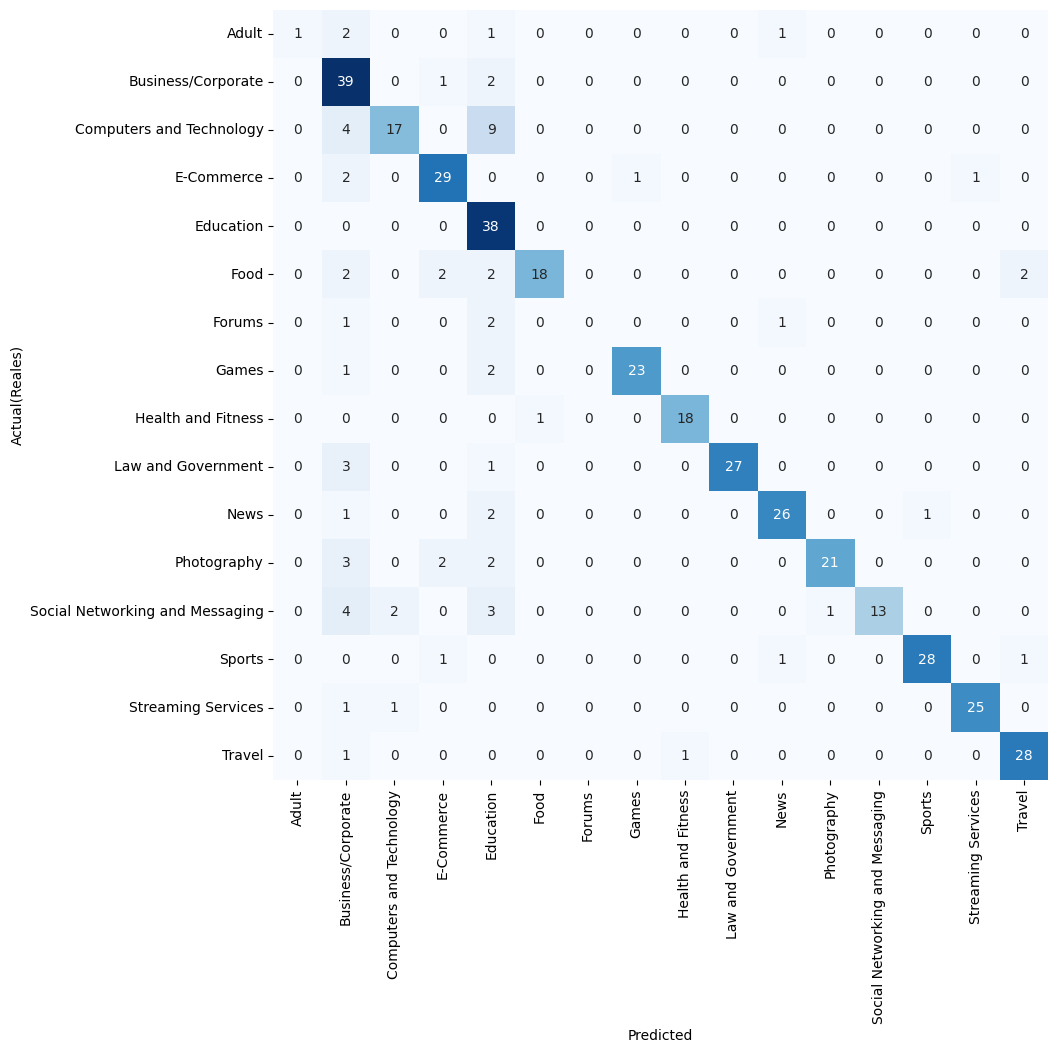

In [273]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_svm, cbar=False, xticklabels=labels, yticklabels=labels,fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual(Reales)')
plt.show()

In [274]:
print(classification_report(y_test_enco, Svmpredic,target_names=labels))

                                 precision    recall  f1-score   support

                          Adult       1.00      0.20      0.33         5
             Business/Corporate       0.61      0.93      0.74        42
       Computers and Technology       0.85      0.57      0.68        30
                     E-Commerce       0.83      0.88      0.85        33
                      Education       0.59      1.00      0.75        38
                           Food       0.95      0.69      0.80        26
                         Forums       0.00      0.00      0.00         4
                          Games       0.96      0.88      0.92        26
             Health and Fitness       0.95      0.95      0.95        19
             Law and Government       1.00      0.87      0.93        31
                           News       0.90      0.87      0.88        30
                    Photography       0.95      0.75      0.84        28
Social Networking and Messaging       1.00      0.

d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [284]:
pickle.dump(
    Svm, open(SKLEARN_SVMMODEL_PATH, "wb")
)

## LogisticRegression

In [224]:
logreg_clf = LogisticRegression()

In [225]:
logreg_clf.fit(x_train_array, y_train_enco)

LogisticRegression()

In [227]:
lrpredint = logreg_clf.predict(X_test_array)

In [228]:
cm_LR = confusion_matrix(y_test_enco, lrpredint)

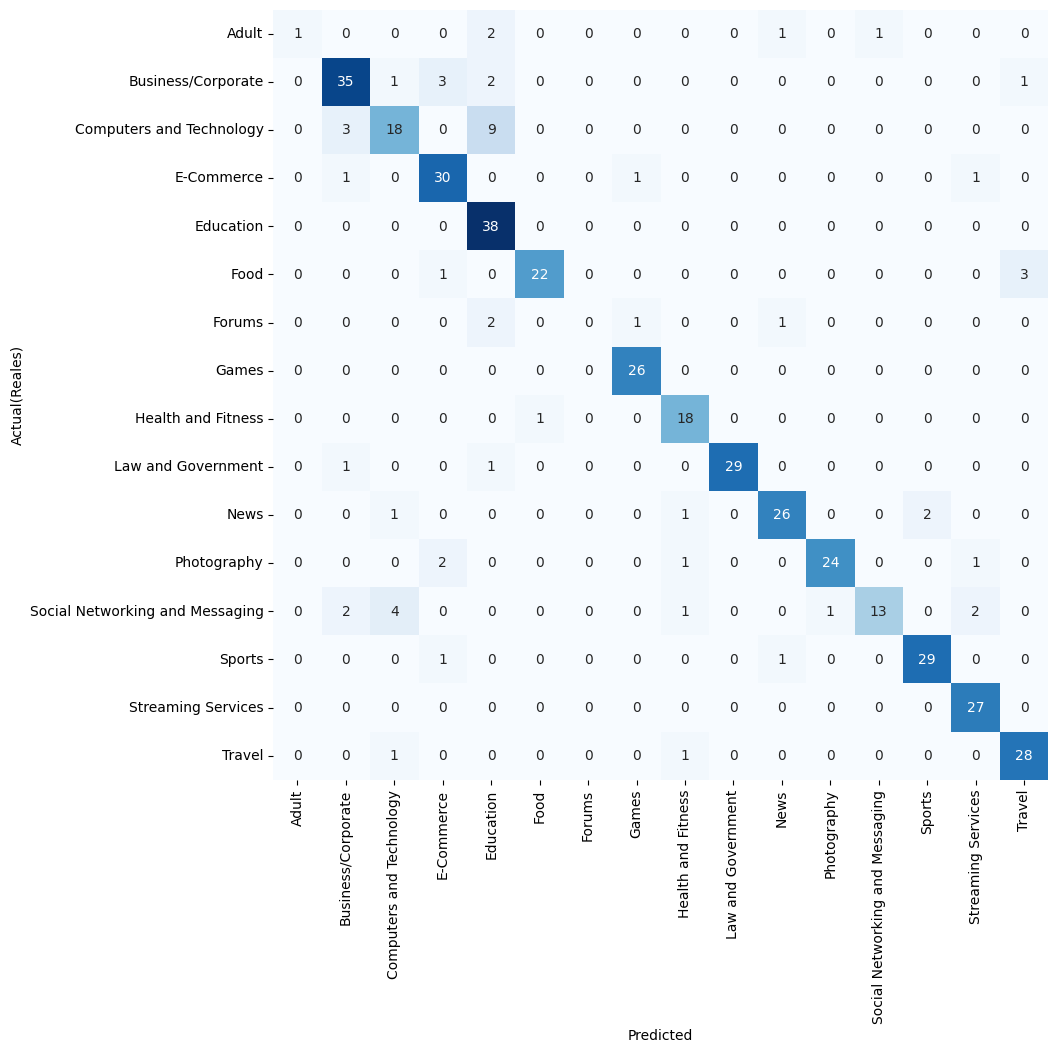

In [229]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_LR, cbar=False, xticklabels=labels, yticklabels=labels,fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual(Reales)')
plt.show()

In [230]:
print(classification_report(y_test_enco, lrpredint,target_names=labels))

                                 precision    recall  f1-score   support

                          Adult       1.00      0.20      0.33         5
             Business/Corporate       0.83      0.83      0.83        42
       Computers and Technology       0.72      0.60      0.65        30
                     E-Commerce       0.81      0.91      0.86        33
                      Education       0.70      1.00      0.83        38
                           Food       0.96      0.85      0.90        26
                         Forums       0.00      0.00      0.00         4
                          Games       0.93      1.00      0.96        26
             Health and Fitness       0.82      0.95      0.88        19
             Law and Government       1.00      0.94      0.97        31
                           News       0.90      0.87      0.88        30
                    Photography       0.96      0.86      0.91        28
Social Networking and Messaging       0.93      0.

d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [285]:
pickle.dump(
    logreg_clf, open(SKLEARN_LRMODEL_PATH, "wb")
)

## RandomForestClassifier

In [263]:
clf = RandomForestClassifier(max_depth=8, random_state=0)

In [264]:
clf.fit(x_train_array, y_train_enco)

RandomForestClassifier(max_depth=8, random_state=0)

In [265]:
rfpredict = clf.predict(X_test_array)

In [266]:
cm_RF = confusion_matrix(y_test_enco, rfpredict)

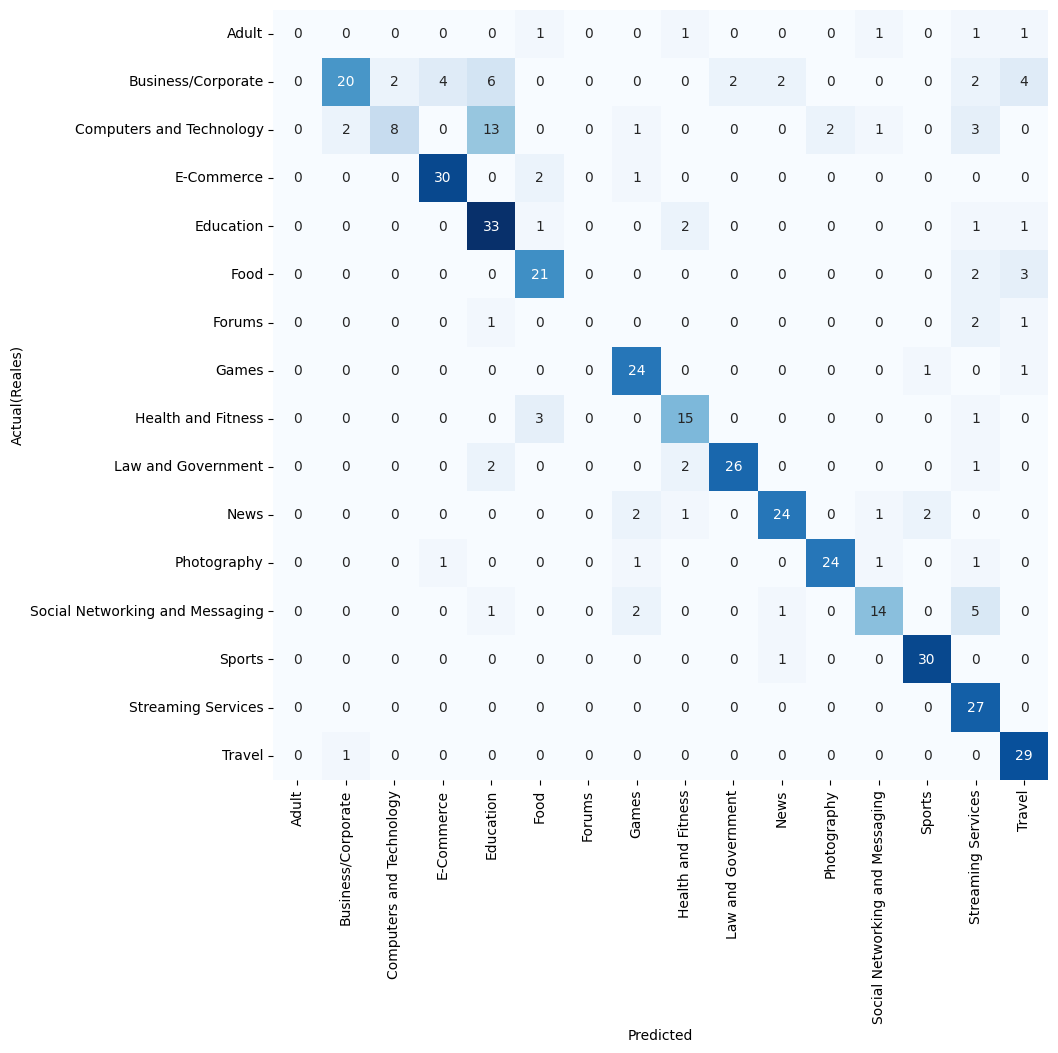

In [267]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_RF, cbar=False, xticklabels=labels, yticklabels=labels,fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual(Reales)')
plt.show()

In [268]:
print(classification_report(y_test_enco, rfpredict,target_names=labels))

                                 precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         5
             Business/Corporate       0.87      0.48      0.62        42
       Computers and Technology       0.80      0.27      0.40        30
                     E-Commerce       0.86      0.91      0.88        33
                      Education       0.59      0.87      0.70        38
                           Food       0.75      0.81      0.78        26
                         Forums       0.00      0.00      0.00         4
                          Games       0.77      0.92      0.84        26
             Health and Fitness       0.71      0.79      0.75        19
             Law and Government       0.93      0.84      0.88        31
                           News       0.86      0.80      0.83        30
                    Photography       0.92      0.86      0.89        28
Social Networking and Messaging       0.78      0.

d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Workspace\FullStack-AI-2023\LinkScribe\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [286]:
pickle.dump(
    clf, open(SKLEARN_RFMODEL_PATH, "wb")
)

## Tensorflow

In [33]:
entrada = LK.Input(shape=(59995))
fc1 = LK.Dense(200, activation='relu')(entrada)
drop1 = LK.Dropout(0.2)(fc1)
fc2 = LK.Dense(80, activation='relu')(drop1)
drop2 = LK.Dropout(0.2)(fc2)
salida = LK.Dense(16, activation='softmax')(drop2)
modelo = MK.Model(entrada,salida)
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59995)]           0         
                                                                 
 dense (Dense)               (None, 200)               11999200  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1296      
                                                                 
Total params: 12016576 (45.84 MB)
Trainable params: 12016576 

In [34]:
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
history = modelo.fit(x_train_array,y_train_enco,epochs=500, validation_data=(X_test_array,y_test_enco),callbacks=[ES], verbose=1)
loss, acc = modelo.evaluate(X_test_array,y_test_enco, verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss, acc))

Epoch 1/500


31/31 [==============================] - 4s 111ms/step - loss: 2.6635 - accuracy: 0.3929 - val_loss: 2.4637 - val_accuracy: 0.6028
Epoch 2/500
31/31 [==============================] - 3s 97ms/step - loss: 1.9074 - accuracy: 0.8142 - val_loss: 1.6538 - val_accuracy: 0.7754
Epoch 3/500
31/31 [==============================] - 3s 98ms/step - loss: 0.8622 - accuracy: 0.9492 - val_loss: 0.9679 - val_accuracy: 0.8676
Epoch 4/500
31/31 [==============================] - 3s 96ms/step - loss: 0.3158 - accuracy: 0.9766 - val_loss: 0.7062 - val_accuracy: 0.8771
Epoch 5/500
31/31 [==============================] - 3s 96ms/step - loss: 0.1497 - accuracy: 0.9888 - val_loss: 0.5727 - val_accuracy: 0.9007
Epoch 6/500
31/31 [==============================] - 3s 96ms/step - loss: 0.0834 - accuracy: 0.9970 - val_loss: 0.5215 - val_accuracy: 0.8983
Epoch 7/500
31/31 [==============================] - 3s 96ms/step - loss: 0.0485 - accuracy: 1.0000 - val_loss: 0.4865 - val_accuracy: 0.8913
Epoch 8/500
31/31

In [37]:
predicciones = modelo.predict(X_test_array)

14/14 [==============================] - 0s 8ms/step


In [38]:
print(predicciones.argmax(1))

[14  9 11  4  4  2 15  1  5 11  5  7  9 13  4  1  5 15  4  1  4  4  9  3
  3  2 14  1  1 11  1  2 13  2  4 14  9  7 11  4  4  7 13 13 14 14 11  5
  9  4  1  7  0 14  7  5 11  5  1  1 11  7 11 13  5  4  9  1  1  3 13 13
  3  9  7 14  2  3  4  3 10  7 11 13  9  8 11 12  9 10 10 13 12 12  4  2
  4  4 15 11  4  1  9 15  3 15  7 11 15 15  1  7  2 13  0  9  7 13  5 13
  5 15  1 10  4 10  5  5  9  5  5  5  1  8 15 14  8  5  8  3  7 10 15  4
  6 10  2  8  2  1  7  4 11 10  9 14  4 11  2  5  3 14 11  1  4 11  1 12
 13  7  1  8 10  9 14  4  7 13 15  3  5  1  7  3  7  7 10 14  3  3 11 10
  3  4  5  1  1  8  2  3 12  4 12  4 14  1  5 10  9  4  4 11 12 14 15 12
  9  1 10 12 15  9  8  1 13  1  1  4  8 13 12 14 15 15 13 10  9 12 12 14
 13  8  4 13  5  9 12  2  3 13 10 15 11 10 11  7 10 15 12  4  2 10 15  3
  8  5  9  5 14 10  4  8  9  7  3  3  3 14  5  9 15 10  8  4 13  1 11  9
 15 14  2 13  2  4  3 11  1 13  9  3  5  4  4  8  3  4  3 10 14 14 13  3
  4  4 11  1 11 12  2 15 10  9  3 11 12 15  0 10  9

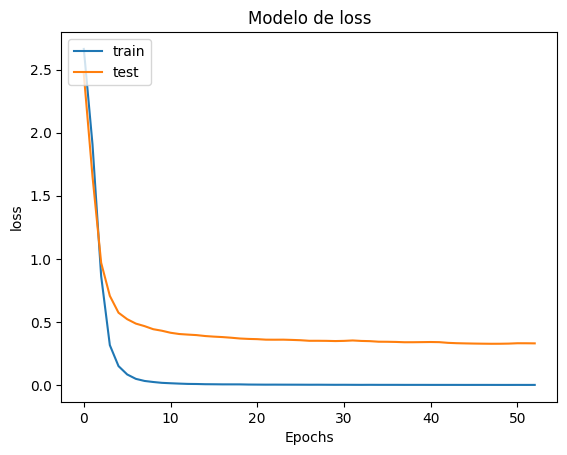

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title ('Modelo de loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

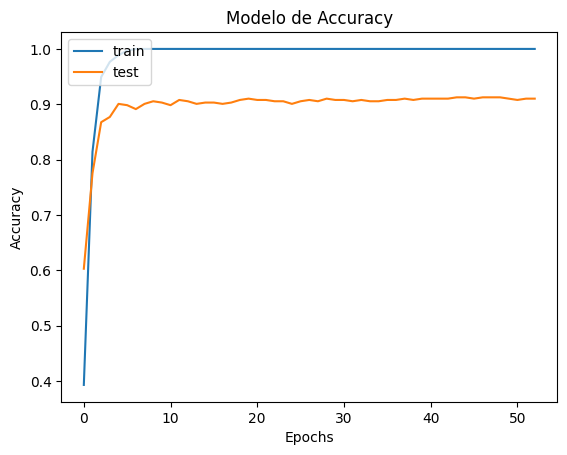

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title ('Modelo de Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [41]:
cm = confusion_matrix(y_test_enco, predicciones.argmax(1))

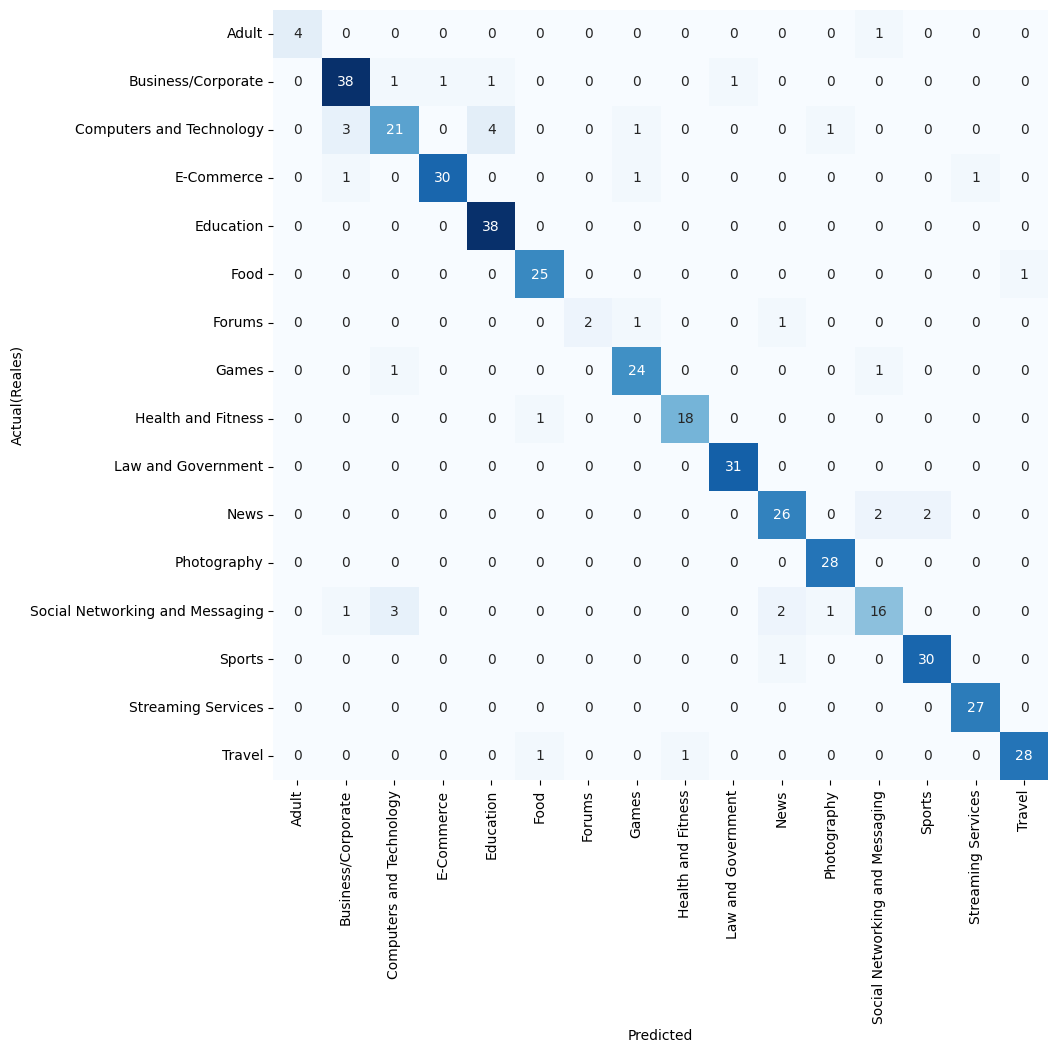

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels,fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual(Reales)')
plt.show()

In [43]:
print(classification_report(y_test_enco, predicciones.argmax(1),target_names=labels))

                                 precision    recall  f1-score   support

                          Adult       1.00      0.80      0.89         5
             Business/Corporate       0.88      0.90      0.89        42
       Computers and Technology       0.81      0.70      0.75        30
                     E-Commerce       0.97      0.91      0.94        33
                      Education       0.88      1.00      0.94        38
                           Food       0.93      0.96      0.94        26
                         Forums       1.00      0.50      0.67         4
                          Games       0.89      0.92      0.91        26
             Health and Fitness       0.95      0.95      0.95        19
             Law and Government       0.97      1.00      0.98        31
                           News       0.87      0.87      0.87        30
                    Photography       0.93      1.00      0.97        28
Social Networking and Messaging       0.80      0.

In [278]:
modelo.save(TF_MODEL_PATH, save_format='tf')

INFO:tensorflow:Assets written to: models\tf\Linscribe_model\assets


INFO:tensorflow:Assets written to: models\tf\Linscribe_model\assets


## web s

In [44]:
!pip3 install beautifulsoup4
!pip3 install lxml

  Obtaining dependency information for lxml from https://files.pythonhosted.org/packages/31/58/e3b3dd6bb2ab7404f1f4992e2d0e6926ed40cef8ce1b3bbefd95877499e1/lxml-4.9.3-cp311-cp311-win_amd64.whl.metadata
  Using cached lxml-4.9.3-cp311-cp311-win_amd64.whl.metadata (3.9 kB)
Using cached lxml-4.9.3-cp311-cp311-win_amd64.whl (3.8 MB)


In [14]:
import requests
import pandas as pd
import string
import re
from bs4 import BeautifulSoup
import lxml
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
def get_title(html):
    """Scrape page title."""
    if html.find("title"):
        title = html.find("title").string
    elif html.find("meta", property="og:title"):
        title = html.find("meta", property="og:title").get('content').string
    elif html.find("h1"):
        title = html.find("h1").string
    return title


def get_description(html):
    """Scrape page description."""
    if html.find("meta", property="description"):
        description = html.find("meta", property="description").get('content')
    elif html.find("meta", property="og:description"):
        description = html.find("meta", property="og:description").get('content')
    elif html.find("p"):
        description = html.find("p").contents
    return description


def get_image(html):
    """Scrape share image."""
    if html.find("meta", property="image"):
        image = html.find("meta", property="image").get('content')
    elif html.find("meta", property="og:image"):
        image = html.find("meta", property="og:image").get('content')
    elif html.find("img", src=True):
        image = html.find("img").get('src')
    return image

In [16]:
url = 'https://www.booking.com/'
req = requests.get(url, headers)
html = BeautifulSoup(req.content, 'lxml')

In [17]:
title = get_title(html)
print(title)
description = get_description(html)
print(description)
image = get_image(html)
print(image)


Booking.com | Official site | The best hotels, flights, car rentals & accommodations 

Whether you’re looking for hotels, homes, or vacation rentals, you’ll always find the guaranteed best price. Browse our 2,563,380 accommodations in over 85,000 destinations.
https://cf.bstatic.com/static/img/fb/10/98dc0cdee5755b6057f9238179476ac705948dba.jpg


In [18]:
datos = [{'descripcion': description}]

In [20]:
description_arr = pd.DataFrame([{'descripcion': description}])

In [21]:
description_arr

,descripcion
0,"Whether you’re looking for hotels, homes, or v..."


In [22]:
description_arr['descripcion']= description_arr['descripcion'].apply(lambda x:x.lower())

In [23]:
description_arr

,descripcion
0,"whether you’re looking for hotels, homes, or v..."


In [24]:
description_arr['tokenized_words'] = description_arr['descripcion'].apply(lambda x:word_tokenize(x))

In [25]:
description_arr['tokenized_words'] = description_arr['tokenized_words'].apply(lambda x:[re.sub(f'[{string.punctuation}]+','',i) for i in x if i not in list(string.punctuation)])

In [26]:
description_arr['tokenized_words']= description_arr['tokenized_words'].apply(lambda x:' '.join(x))

In [27]:
description_arr=description_arr[['tokenized_words']]
description_arr

,tokenized_words
0,whether you ’ re looking for hotels homes or v...


In [28]:
X_web = description_arr['tokenized_words']

In [29]:
print(X_web)

0    whether you ’ re looking for hotels homes or v...
Name: tokenized_words, dtype: object


In [62]:
X_web_count = count.transform(X_web)
print(X_web_count)

  (0, 1051)	1
  (0, 5980)	1
  (0, 7845)	1
  (0, 14361)	1
  (0, 19212)	1
  (0, 22407)	1
  (0, 24246)	1
  (0, 24468)	1
  (0, 31115)	1
  (0, 41973)	1
  (0, 44553)	1
  (0, 56191)	1


In [64]:
X_web_Tfidf = Tfidf.transform(X_web_count)
print(X_web_Tfidf)

  (0, 56191)	0.26665390338983685
  (0, 44553)	0.33599560980025095
  (0, 41973)	0.18248950099497946
  (0, 31115)	0.3629946060530389
  (0, 24468)	0.2547525720579243
  (0, 24246)	0.34803741980644004
  (0, 22407)	0.36890586808715126
  (0, 19212)	0.10952964737596893
  (0, 14361)	0.29485723472978836
  (0, 7845)	0.19694628849520981
  (0, 5980)	0.1954148203600308
  (0, 1051)	0.3910273147044254


In [58]:
X_web_array = X_web_Tfidf.toarray()

In [65]:
print(X_web_array)

[[0. 0. 0. ... 0. 0. 0.]]


In [67]:
modelo = tf.keras.models.load_model("models/tf/Linscribe_model")

In [68]:
prediccion = modelo.predict(X_web_array)

1/1 [==============================] - 0s 84ms/step


In [77]:
prediccion

array([[2.0572920e-03, 9.1173110e-04, 5.4333828e-05, 1.3191279e-03,
        4.9755571e-04, 1.8626284e-03, 5.0178793e-04, 2.5138783e-04,
        1.1327977e-03, 1.1524130e-03, 5.0104433e-04, 5.5220025e-04,
        1.5382617e-03, 4.2518779e-05, 5.0130318e-04, 9.8712361e-01]],
      dtype=float32)

In [76]:
print(le.inverse_transform(prediccion.argmax(1)))

['Travel']
